In [38]:
import sqlite3
import pandas as pd
import matplotlib as rc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


In [39]:
#------------------------------------------------------------------------------
# accept a dataframe, remove outliers, return cleaned data in a new dataframe
# see http://www.itl.nist.gov/div898/handbook/prc/section1/prc16.htm
#------------------------------------------------------------------------------
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out


In [40]:
# set style for seaborn
sns.set_style("whitegrid")
sns.set_context("paper")
# plt.rc('text', usetex=True)
# plt.rc('font', family='serif')


In [41]:
# connect to database
connection = sqlite3.connect("../output/db/bulk_analysis_2019-11-08_1000ms.db")


In [64]:
# load games and moves into dataframes 
df_game_dirty = pd.read_sql("SELECT * FROM game", connection)
df_move_dirty = pd.read_sql("SELECT id, game_id, ply_number, threats_count_all, unopposed_threats_count_all, (threats_count_all-unopposed_threats_count_all) as defended_threats_count_all  FROM move", connection)
df_move_avg_dirty = pd.read_sql("SELECT id, game_id, ply_number, avg(threats_count_all) as threats_count_all, avg(unopposed_threats_count_all) as unopposed_threats_count_all, avg(threats_count_all-unopposed_threats_count_all) as defended_threats_count_all  FROM move GROUP BY ply_number;", connection)

# remove games that are either too short or too long
df_game = remove_outlier(df_game_dirty, "length")
df_move = df_move_dirty[df_move_dirty["game_id"].isin(df_game["id"])]
df_move_avg = df_move_avg_dirty[df_move_avg_dirty["game_id"].isin(df_game["id"])]


In [65]:
# df_move.apply(lambda row: row.threats_count_all - row.unopposed_threats_count_all, axis=1)
# df_move["defended_threats_count_all"] = df_move.apply(lambda row: row.threats_count_all - row.unopposed_threats_count_all, axis=1)


In [74]:
df_move_melted = pd.melt(df_move, id_vars=["id", "ply_number"], value_vars=["unopposed_threats_count_all", "defended_threats_count_all"])
df_move_melted.head()

,id,ply_number,variable,value
0,1,1,unopposed_threats_count_all,0
1,2,2,unopposed_threats_count_all,0
2,3,3,unopposed_threats_count_all,0
3,4,4,unopposed_threats_count_all,0
4,5,5,unopposed_threats_count_all,0


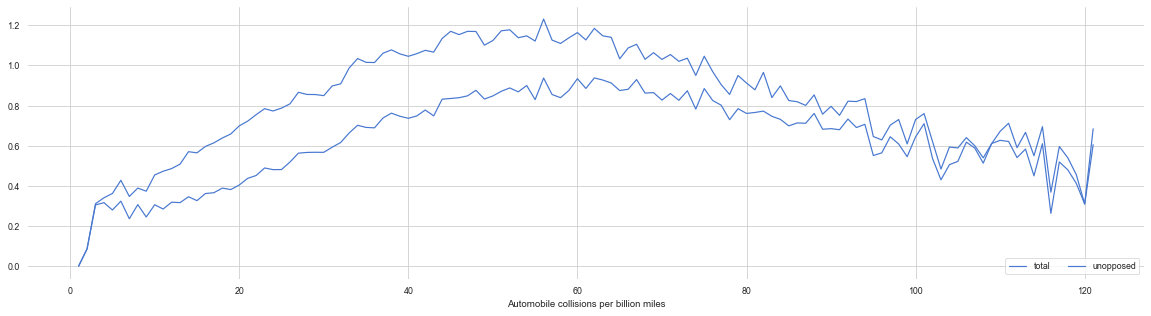

In [75]:
# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(20, 5))
# Plot the total crashes
sns.set_color_codes("pastel")
sns.lineplot(x="ply_number", y="threats_count_all", data=df_move_avg,
            label="total", color="b")

# Plot the crashes where alcohol was involved
sns.set_color_codes("muted")
sns.lineplot(x="ply_number", y="unopposed_threats_count_all", data=df_move_avg,
            label="unopposed", color="b")

# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(ylabel="",
       xlabel="Automobile collisions per billion miles")
sns.despine(left=True, bottom=True)

In [76]:

#plt.stackplot(df_move_melted["ply_number"], df_move_melted["value"], labels=["unopposed_threats_count_all", "defended_threats_count_all"])
#plt.show()

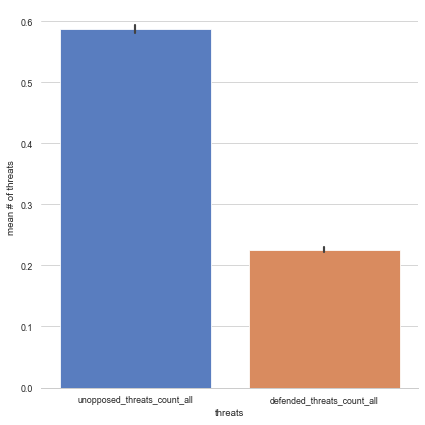

In [77]:
g = sns.catplot(x="variable", y="value", data=df_move_melted,
                height=6, kind="bar", palette="muted")
g.despine(left=True)
g.set_xlabels("threats")
g.set_ylabels("mean # of threats")

